In [35]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import cv2
import multiprocessing as mp
from time import sleep
import workers # custom script
%matplotlib inline

In [36]:
image = cv2.imread('Pirate.tif', 0)

In [37]:
def create_noisy_image(image, noise_std):
    np.random.seed(2021)
    noisy_image = image + np.random.normal(scale=noise_std, size=image.shape)
    return np.clip(noisy_image, 0, 255)

In [38]:
def plot_image(image, legend):
    fig, ax = plt.subplots(1)
    ax.imshow(image, interpolation='nearest', cmap = 'gray')
    ax.text(20, 30, legend, bbox={'facecolor': 'white', 'pad': 10}, size = 16)
    fig.set_figheight(10)
    fig.set_figwidth(10)

In [39]:
def tv_denoise_core_parallel(noisy_image, delta, eps, L, mu, maxiter):
        pobj = 0
        dobj = 0
        res_l = []
        m, n = noisy_image.shape
        mn = m * n
        noisy_image = noisy_image.flatten()
        x = noisy_image.copy()
        wk = np.zeros(mn)
        uij = np.zeros(2)
        print(f'Maxiter:{maxiter}')
        for k in range(maxiter):
            print(f'{k} iteration')
            df = np.zeros(mn)
            pobj = 0
            # step1
            for j in range(n - 1):
                for i in range(m - 1):
                    i1 = (i + 1) + j * m
                    i2 = i + (j + 1) * m
                    i3 = i + j * m
                    uij[0] = x[i1] - x[i3]
                    uij[1] = x[i2] - x[i3]
                    
                    c1 = np.linalg.norm(uij)
                    pobj += c1
                    
                    c2 = max(mu, c1)
                    uij = uij / c2
                    
                    df[i1] += uij[0]
                    df[i3] -= uij[0]
                    df[i2] += uij[1]
                    df[i3] -= uij[1]
                    
            dobj = df.dot(noisy_image) - delta * np.linalg.norm(df)
            res = pobj - dobj
            print(res)
            res_l.append(res)
            if res < eps:
                break
        #step 2
            y_k = (L * (x - noisy_image) - df)/ (max(L, np.linalg.norm(L * (x - noisy_image) - df) / delta)) + noisy_image
        #step3
            wk += ((k + 1) / 2) * df
            zk = -wk / max(L, np.linalg.norm(wk) / delta) + noisy_image
        #step4
            x = 2 /(k + 3) *zk + (k + 1)/(k + 3) * y_k
        return x, res_l

In [40]:
def tv_denoise_core(noisy_image, delta, eps, L, mu, maxiter): 
        pobj = 0
        dobj = 0
        res_l = []
        m = noisy_image.shape[0]
        n = noisy_image.shape[1]
        mn = m * n
        noisy_image = noisy_image.flatten()
        wk = np.zeros(mn)
        x = noisy_image.copy()
        uij = np.zeros(2)
        print(f'Maxiter:{maxiter}')
        for k in range(maxiter):
            print(f'{k} iteration')
            pobj = 0
            df = np.zeros(mn)
            # step1
            for j in range(n - 1):
                for i in range(m - 1):
                    i1 = (i + 1) + j * m
                    i2 = i + (j + 1) * m
                    i3 = i + j * m
                    uij[0] = x[i1] - x[i3]
                    uij[1] = x[i2] - x[i3]
                    
                    c1 = np.linalg.norm(uij)
                    pobj += c1
                    
                    c2 = max(mu, c1)
                    uij = uij / c2
                                        
                    df[i1] += uij[0]
                    df[i3] -= uij[0]
                    df[i2] += uij[1]
                    df[i3] -= uij[1]
                    
            dobj = df.dot(noisy_image) - delta * np.linalg.norm(df)
            res = pobj - dobj
            print(res)
            res_l.append(res)
            if res < eps:
                break
            with mp.Pool(2) as pool: # step 2 step 3 in parallel
                results = [pool.apply_async(workers.y_count, (L, x, noisy_image, df, delta)),
                           pool.apply_async(workers.z_count, (wk, k, df, L, delta, noisy_image))]
                y_k = results[0].get()
                wk, zk = results[1].get()
            #step4
            x = ((2 /(k + 3)) * zk) + (((k + 1)/(k + 3)) * y_k)
        return x, res_l

In [42]:
def TVdenoise(noisy_image, delta, sigma, tau, parallel, eps_rel = 1e-3):
    alpha = np.sum(noisy_image.flatten()) / len(noisy_image)
    X = alpha * np.ones(noisy_image.shape)
    mdelta = np.linalg.norm(X - noisy_image, 'fro')
    if mdelta < delta:
        return noisy_image # noisy image is a solution (noise is low)
    elif mdelta < 1.1 * delta:
        print('Convergence problems may arise')
    R = noisy_image.max()
    mn = noisy_image.shape[0] * noisy_image.shape[1]
    epsilon = R * mn * eps_rel
    mu = epsilon / mn
    Lmu = 8 / mu
    N = ((4 * np.sqrt(2) * tau * sigma) / (eps_rel * R)).astype(int) # maxiter 
    if parallel:
        X, res = tv_denoise_core_parallel(noisy_image, delta, epsilon, Lmu, mu, N) 
    else:
        X, res = tv_denoise_core(noisy_image, delta, epsilon, Lmu, mu, N)
    return X, res

In [43]:
def TVdenoise_demonstration(image_path, noise_std, tau, parallel = True):
    image = cv2.imread(image_path, 0)
    noisy_image = create_noisy_image(image, noise_std)
    height = noisy_image.shape[0]
    width = noisy_image.shape[1]
    delta = tau * np.sqrt(height * width) * noise_std #the higher tau the lower denoised img
    denoised_image, res = TVdenoise(noisy_image, delta, noise_std, tau, parallel)
    denoised_image = denoised_image.reshape((height, width)) 
    plot_image(image, 'Clear image')
    plot_image(noisy_image, 'Noisy image')
    plot_image(denoised_image, 'Denoised image')
    return denoised_image, res

# Parallel

Maxiter:471
0 iteration
11129905.782473002
1 iteration
11099901.62418311
2 iteration
11060736.80489142
3 iteration
11012454.417032938
4 iteration
10954627.419192763
5 iteration
10886994.62998658
6 iteration
10809427.998385368
7 iteration
10721667.290081235
8 iteration
10623742.926793307
9 iteration
10515749.475017546
10 iteration
10397372.452103699
11 iteration
10269609.76443172
12 iteration
10132047.715875968
13 iteration
9984732.188159423
14 iteration
9827934.495408015
15 iteration
9662099.51405652
16 iteration
9487641.87316468
17 iteration
9304579.224490901
18 iteration
9112672.742802227
19 iteration
8913326.849719435
20 iteration
8706590.969925698
21 iteration
8493172.3070275
22 iteration
8273316.87627252
23 iteration
8048895.851650599
24 iteration
7819008.427982004
25 iteration
7585934.177371608
26 iteration
7350845.793259839
27 iteration
7115083.114079613
28 iteration
6878862.718763973
29 iteration
6645379.17342292
30 iteration
6415748.460964175
31 iteration
6191612.090969788
32 

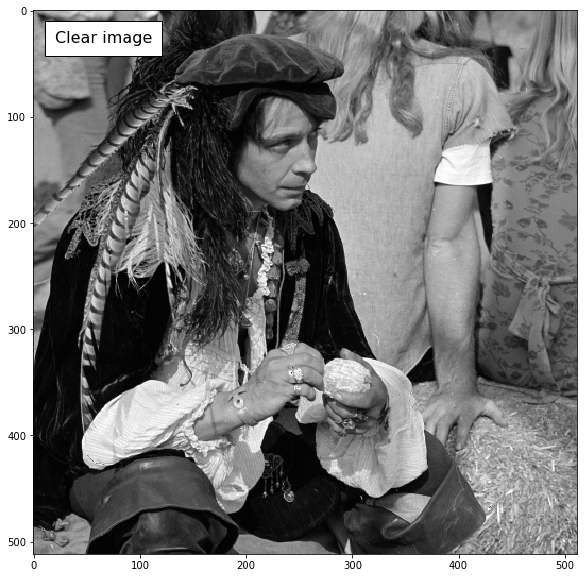

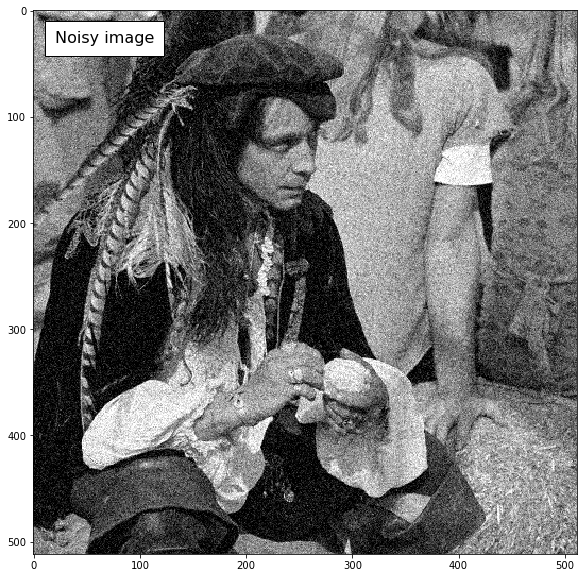

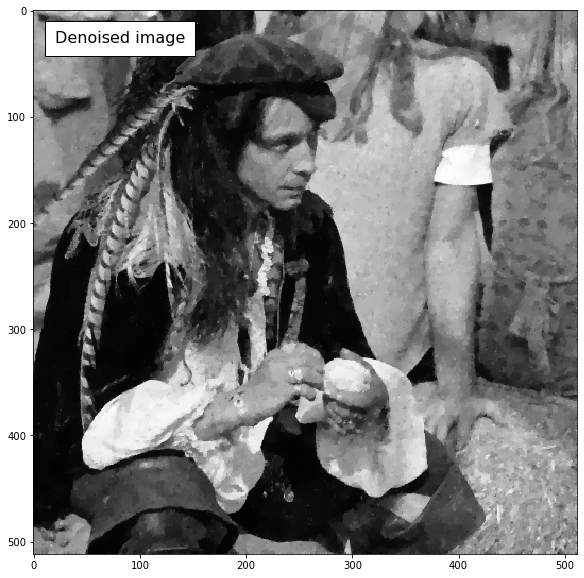

In [44]:
%%time
denoised_img, resid = TVdenoise_demonstration('Pirate.tif', 25, 0.85, True)

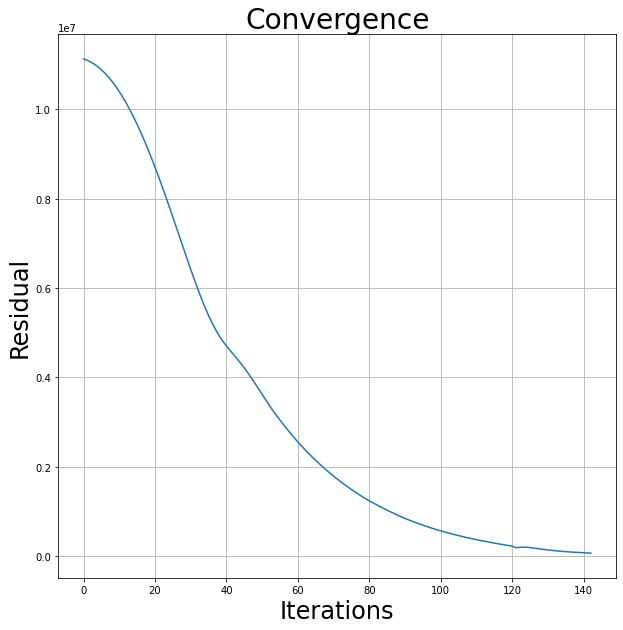

In [45]:
plt.figure(figsize=(10, 10))
plt.plot(resid)
plt.grid(True)
plt.xlabel('Iterations', size=24)
plt.ylabel('Residual', size=24)
plt.title('Convergence', size=28);

# Not parallel

Maxiter:471
0 iteration
11129905.782473002
1 iteration
11099901.62418311
2 iteration
11060736.80489142
3 iteration
11012454.417032938
4 iteration
10954627.419192763
5 iteration
10886994.62998658
6 iteration
10809427.998385368
7 iteration
10721667.290081235
8 iteration
10623742.926793307
9 iteration
10515749.475017546
10 iteration
10397372.452103699
11 iteration
10269609.76443172
12 iteration
10132047.715875968
13 iteration
9984732.188159423
14 iteration
9827934.495408015
15 iteration
9662099.51405652
16 iteration
9487641.87316468
17 iteration
9304579.224490901
18 iteration
9112672.742802227
19 iteration
8913326.849719435
20 iteration
8706590.969925698
21 iteration
8493172.3070275
22 iteration
8273316.87627252
23 iteration
8048895.851650599
24 iteration
7819008.427982004
25 iteration
7585934.177371608
26 iteration
7350845.793259839
27 iteration
7115083.114079613
28 iteration
6878862.718763973
29 iteration
6645379.17342292
30 iteration
6415748.460964175
31 iteration
6191612.090969788
32 

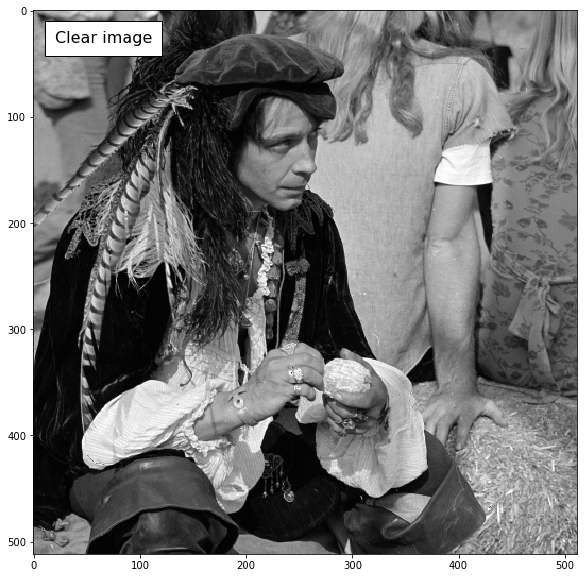

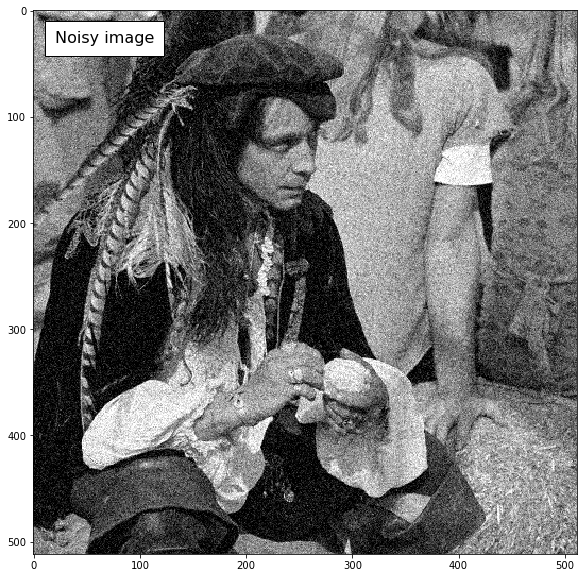

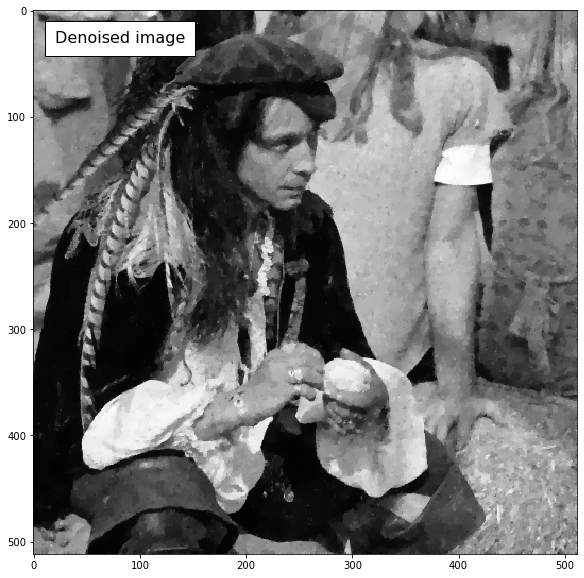

In [46]:
%%time
denoised_img, res = TVdenoise_demonstration('Pirate.tif', 25, 0.85, False)

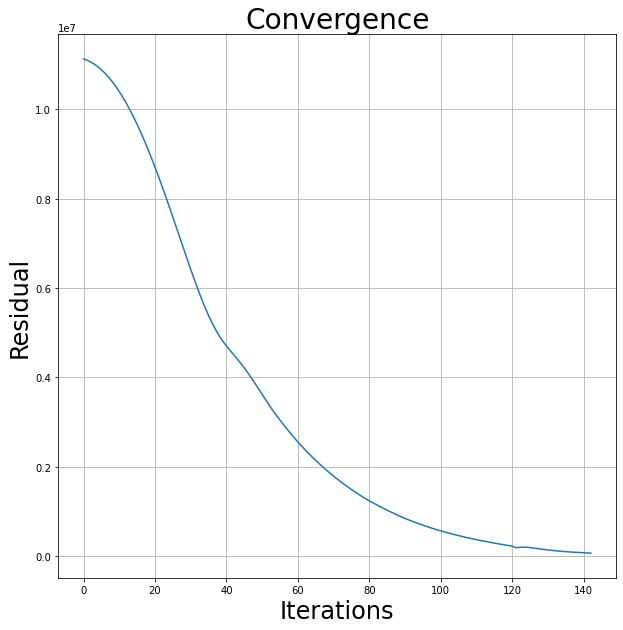

In [47]:
plt.figure(figsize=(10, 10))
plt.plot(resid)
plt.grid(True)
plt.xlabel('Iterations', size=24)
plt.ylabel('Residual', size=24)
plt.title('Convergence', size=28);

# Change Tau

Maxiter:665
0 iteration
15712806.569725802
1 iteration
15679576.43659723
2 iteration
15636822.766631812
3 iteration
15584589.864997031
4 iteration
15522251.037334112
5 iteration
15449406.214439806
6 iteration
15365838.762857603
7 iteration
15271129.919516012
8 iteration
15165265.135098496
9 iteration
15048320.745639099
10 iteration
14919743.74027543
11 iteration
14780882.275364257
12 iteration
14631072.181496097
13 iteration
14470260.157760022
14 iteration
14298676.588890644
15 iteration
14116836.190260777
16 iteration
13925076.40883492
17 iteration
13723339.868826246
18 iteration
13511028.89542818
19 iteration
13289952.205092184
20 iteration
13059787.394337745
21 iteration
12821207.963782858
22 iteration
12574268.298996318
23 iteration
12321221.358011154
24 iteration
12060322.861387203
25 iteration
11794711.717521317
26 iteration
11525274.337344712
27 iteration
11253551.04846803
28 iteration
10979286.422607627
29 iteration
10706132.364703707
30 iteration
10435314.648417965
31 iteratio

206660.7237534545
257 iteration
203309.94812034268
258 iteration
200254.39745506598
259 iteration
197217.71577456
260 iteration
193724.58867074747
261 iteration
190180.97387171164
262 iteration
186763.0532418202
263 iteration
183524.10567096376
264 iteration
180551.89013304212
265 iteration
177585.8624679509
266 iteration
174642.37154904997
267 iteration
171715.6741856233
268 iteration
168797.48038844182
269 iteration
165751.53015299758
270 iteration
162911.3906148608
271 iteration
160190.83848543954
272 iteration
157683.79933476832
273 iteration
155359.06637135742
274 iteration
153218.6719676616
275 iteration
150958.11000646162
276 iteration
148844.99079962552
277 iteration
146808.53855885973
278 iteration
144547.35357872944
279 iteration
142085.21426373115
280 iteration
139621.52079492575
281 iteration
137645.99602225877
282 iteration
135746.91041392472
283 iteration
133737.94190087705
284 iteration
131629.69010629947
285 iteration
129535.95929689961
286 iteration
127533.97103139805


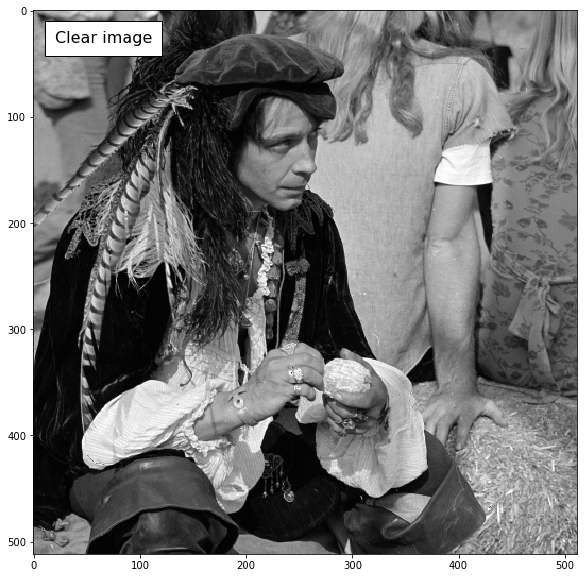

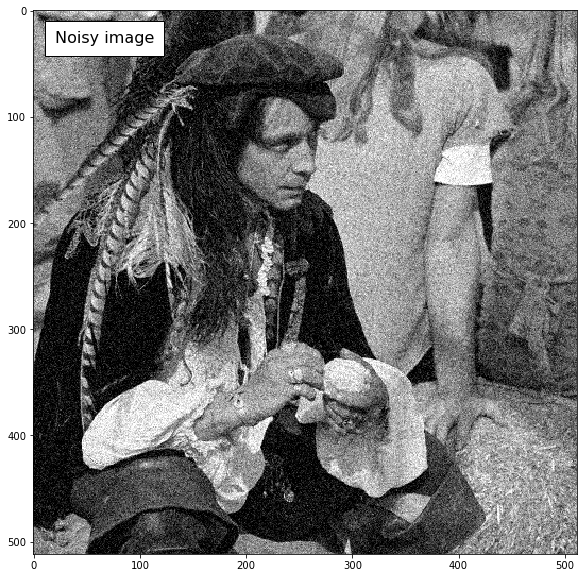

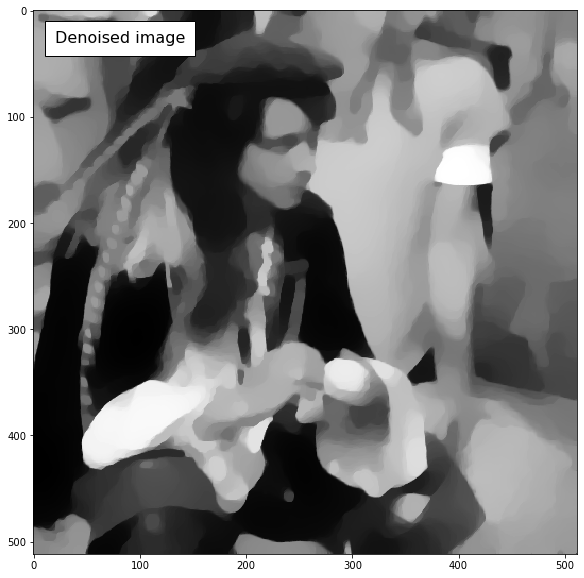

In [48]:
%%time
denoised_img, resid = TVdenoise_demonstration('Pirate.tif', 25, 1.2, False)

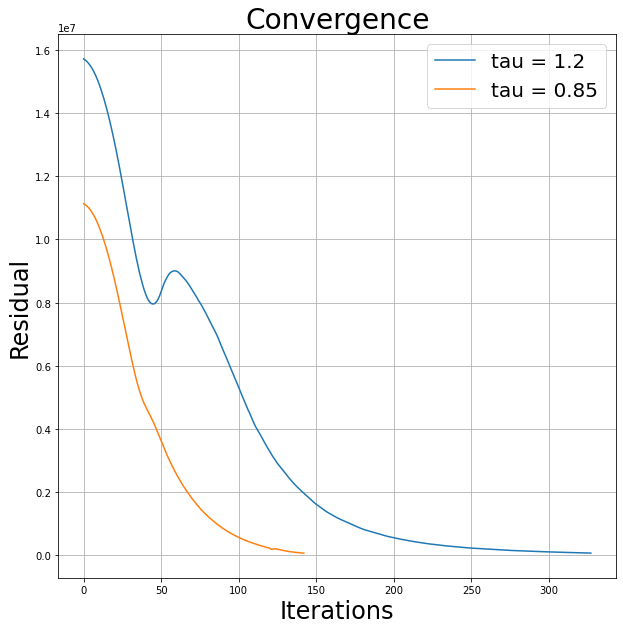

In [49]:
plt.figure(figsize=(10, 10))
plt.plot(resid, label = 'tau = 1.2')
plt.plot(res, label = 'tau = 0.85')
plt.legend(prop={'size': 20})
plt.grid(True)
plt.xlabel('Iterations', size=24)
plt.ylabel('Residual', size=24)
plt.title('Convergence', size=28);